<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_4_advanced_neurons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)

# snnTorch - 2nd Order Spiking Neuron Models
## Tutorial 4
### By Jason K. Eshraghian (www.jasoneshraghian.com)

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_4_advanced_neurons.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)

The snnTorch tutorial series is based on the following paper. If you find these resources or code useful in your work, please consider citing the following source:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". arXiv preprint arXiv:2109.12894, September 2021.](https://arxiv.org/abs/2109.12894) </cite>


# Introduction
In this tutorial, you will:
* Learn about the more advanced leaky integrate-and-fire (LIF) neuron models available: `Synaptic` and `Alpha`

Install the latest PyPi distribution of snnTorch by clicking into the following cell and pressing `Shift+Enter`.

In [ ]:
!pip install snntorch

In [1]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
#@title Plotting Settings

def plot_spk_cur_mem_spk(spk_in, syn_rec, mem_rec, spk_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(4, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [0.4, 1, 1, 0.4]})

  # Plot input current
  splt.raster(spk_in, ax[0], s=400, c="black", marker="|")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title("Synaptic Conductance-based Neuron Model With Input Spikes")
  ax[0].set_yticks([]) 

  # Plot membrane potential
  ax[1].plot(syn_rec.detach().numpy())
  ax[1].set_ylim([0, 0.5])
  ax[1].set_ylabel("Synaptic Current ($I_{syn}$)")
  plt.xlabel("Time step")

  # Plot membrane potential
  ax[2].plot(mem_rec.detach().numpy())
  ax[2].set_ylim([0, 1.5])
  ax[2].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[2].axhline(y=1, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk_rec, ax[3], s=400, c="black", marker="|")
  plt.ylabel("Output spikes")
  ax[3].set_yticks([]) 

  plt.show()

def plot_spk_mem_spk(spk_in, mem_rec, spk_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [0.4, 1, 0.4]})

  # Plot input current
  splt.raster(spk_in, ax[0], s=400, c="black", marker="|")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)
  ax[0].set_yticks([]) 

  # Plot membrane potential
  ax[1].plot(mem_rec.detach())
  ax[1].set_ylim([0, 0.6])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[1].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk_rec, ax[2], s=400, c="black", marker="|")
  ax[2].set_yticks([])
  ax[2].set_ylabel("Output Spikes")

  plt.show()

# 1. Synaptic Conductance-based LIF Neuron Model
The neuron models explored in previous tutorials assume that an input voltage spike leads to an instantaneous jump in synaptic current, which then contributes to the membrane potential. In reality, a spike will result in the *gradual* release of neurotransmitters from the pre-synaptic neuron to the post-synaptic neuron. The synaptic conductance-based LIF model accounts for the gradual temporal dynamics of input current. 

## 1.1 Modeling Synaptic Current

If a pre-synaptic neuron fires, the voltage spike is transmitted down the axon of the neuron. It triggers the vesicles to release neurotransmitters into the synaptic cleft. These activate the post-synaptic receptors, which directly influence the effective current that flows into the post-synaptic neuron. Shown below are two types of excitatory receptors, AMPA and NMDA.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_6_synaptic.png?raw=true' width="600">
</center>

The simplest model of synaptic current assumes an increasing current on a very fast time-scale, followed by a relatively slow exponential decay, as seen in the AMPA receptor response above. This is very similar to the membrane potential dynamics of Lapicque's model.


The synaptic model has two exponentially decaying terms: $I_{\rm syn}(t)$ and $U_{\rm mem}(t)$. The ratio between subsequent terms (i.e., decay rate) of $I_{\rm syn}(t)$ is set to $\alpha$, and that of $U(t)$ is set to $\beta$:

$$ \alpha = e^{-\Delta t/\tau_{\rm syn}}$$

$$ \beta = e^{-\Delta t/\tau_{\rm mem}}$$

where the duration of a single time step is normalized to $\Delta t = 1$ in future. $\tau_{\rm syn}$ models the time constant of the synaptic current in an analogous way to how $\tau_{\rm mem}$ models the time constant of the membrane potential. $\beta$ is derived in the exact same way as the previous tutorial, with a similar approach to $\alpha$:

$$I_{\rm syn}[t+1]=\underbrace{\alpha I_{\rm syn}[t]}_\text{decay} + \underbrace{WX[t+1]}_\text{input}$$

$$U[t+1] = \underbrace{\beta U[t]}_\text{decay} + \underbrace{I_{\rm syn}[t+1]}_\text{input} - \underbrace{R[t]}_\text{reset}$$

The same conditions for spiking as the previous LIF neurons still hold:

$$S_{\rm out}[t] = \begin{cases} 1, &\text{if}~U[t] > U_{\rm thr} \\
0, &\text{otherwise}\end{cases}$$


## 1.2 Synaptic Neuron Model in snnTorch
The synaptic condutance-based neuron model combines the synaptic current dynamics with the passive membrane. It must be instantiated with two input arguments:
* $\alpha$: the decay rate of the synaptic current
* $\beta$: the decay rate of the membrane potential (as with Lapicque)

In [3]:
# Temporal dynamics
alpha = 0.9
beta = 0.8
num_steps = 200

# Initialize 2nd-order LIF neuron
lif1 = snn.Synaptic(alpha=alpha, beta=beta)

Using this neuron is the exact same as previous LIF neurons, but now with the addition of synaptic current `syn` as an input and output:

**Inputs**
* `spk_in`: each weighted input voltage spike $WX[t]$ is sequentially passed in
* `syn`: synaptic current $I_{\rm syn}[t-1]$ at the previous time step
* `mem`: membrane potential $U[t-1]$ at the previous time step

**Outputs**
* `spk_out`: output spike $S[t]$ ('1' if there is a spike; '0' if there is no spike)
* `syn`: synaptic current $I_{\rm syn}[t]$ at the present time step
* `mem`: membrane potential $U[t]$ at the present time step

These all need to be of type `torch.Tensor`. Note that the neuron model has been time-shifted back one step without loss of generality.

Apply a periodic spiking input to see how current and membrane evolve with time:

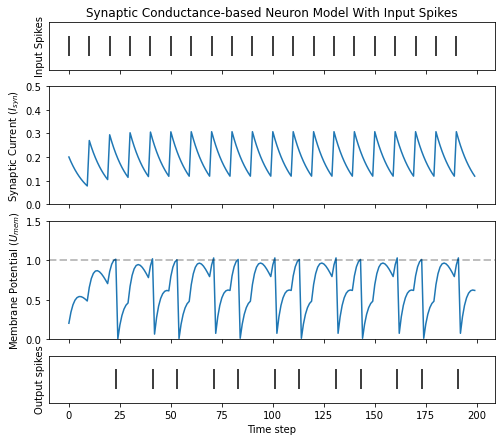

In [4]:
# Periodic spiking input, spk_in = 0.2 V
w = 0.2
spk_period = torch.cat((torch.ones(1)*w, torch.zeros(9)), 0)
spk_in = spk_period.repeat(20)

# Initialize hidden states and output
syn, mem = lif1.init_synaptic()
spk_out = torch.zeros(1) 
syn_rec = []
mem_rec = []
spk_rec = []

# Simulate neurons
for step in range(num_steps):
  spk_out, syn, mem = lif1(spk_in[step], syn, mem)
  spk_rec.append(spk_out)
  syn_rec.append(syn)
  mem_rec.append(mem)

# convert lists to tensors
spk_rec = torch.stack(spk_rec)
syn_rec = torch.stack(syn_rec)
mem_rec = torch.stack(mem_rec)

plot_spk_cur_mem_spk(spk_in, syn_rec, mem_rec, spk_rec, 
                     "Synaptic Conductance-based Neuron Model With Input Spikes")

This model also has the optional input arguments of `reset_mechanism` and `threshold` as described for Lapicque's neuron model. In summary, each spike contributes a shifted exponential decay to the synaptic current $I_{\rm syn}$, which are all summed together. This current is then integrated by the passive membrane equation derived in [Tutorial 2](https://snntorch.readthedocs.io/en/latest/tutorials/index.html), thus generating output spikes. An illustration of this process is provided below.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_7_stein.png?raw=true' width="600">
</center>

## 1.3 1st-Order vs. 2nd-Order Neurons

A natural question that arises is - *when do I want to use a 1st order LIF neuron and when should I use this 2nd order LIF neuron?* While this has not really been settled, my own experiments have given me some intuition that might be useful.

**When 2nd-order neurons are better**
* If the temporal relations of your input data occur across long time-scales,
* or if the input spiking pattern is sparse

By having two recurrent equations with two decay terms ($\alpha$ and $\beta$), this neuron model is able to 'sustain' input spikes over a longer duration. This can be beneficial to retaining long-term relationships.

An alternative use case might also be:

* When temporal codes matter

If you care for the precise timing of a spike, it seems easier to control that for a 2nd-order neuron. In the `Leaky` model, a spike would be triggered in direct synchrony with the input. For 2nd-order models, the membrane potential is 'smoothed out' (i.e., the synaptic current model low-pass filters the membrane potential), which means $U[t]$ experiences a finite rise time. This is clear in the previous simulation, where the output spikes experience a delay with respect to the input spikes.

**When 1st-order neurons are better**
* Any case that doesn't fall into the above, and sometimes, the above cases.

By having one less equation in 1st-order neuron models (such as `Leaky`), the backpropagation process is made a little simpler. Though having said that, the `Synaptic` model is functionally equivalent to the `Leaky` model for $\alpha=0$. In my own hyperparameter sweeps on simple datasets, the optimal results seem to push $\alpha$ as close to 0 as possible. As data increases in complexity, $\alpha$ may grow larger.

# 2. Alpha Neuron Model (Hacked Spike Response Model)

A recursive version of the Spike Response Model (SRM), or the 'Alpha' neuron, is also available, called using `snn.Alpha`. The neuron models thus far have all been based on the passive membrane model, using ordinary differential equations to describe their dynamics.

The SRM family of models, on the other hand, is interpreted in terms of a filter. Upon the arrival of an input spike, this spike is convolved with the filter to give the membrane potential response. The form of this filter can be exponential, as is the case with Lapicque's neuron, or they can be more complex such as a sum of exponentials. SRM models are appealing as they can arbitrarily add refractoriness, threshold adaptation, and any number of other features simply by embedding them into the filter. 

<left>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/exp.gif?raw=true' width="400">
</left> 

<right>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/alpha.gif?raw=true' width="400">
</right> 



## 2.1 Modelling the Alpha Neuron Model
Formally, this process is represented by:

$$U_{\rm mem}(t) = \sum_i W(\epsilon * S_{\rm in})(t)$$

where the incoming spikes $S_{\rm in}$ are convolved with a spike response kernel $\epsilon( \cdot )$. The spike response is scaled by a synaptic weight, $W$. In the figures above, the left kernel is an exponentially decaying function and would be the equivalent of Lapicque's 1st-order neuron model. On the right, the kernel is an alpha function:

$$\epsilon(t) = \frac{t}{\tau}e^{1-t/\tau}\Theta(t)$$

where $\tau$ is the time constant of the alpha kernel and $\Theta$ is the Heaviside step function. Most kernel-based methods adopt the alpha function as it provides a time-delay that is useful for temporal codes that are concerned with specifying the exact spike time of a neuron. 

In snnTorch, the spike response model is not directly implemented as a filter. Instead, it is recast into a recursive form such that only the previous time step of values are required to calculate the next set of values. This significantly reduces the memory overhead during learning.


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_9_alpha.png?raw=true' width="600">
</center> 


As the membrane potential is now determined by the sum of two exponentials, each of these exponents has their own independent decay rate. $\alpha$ defines the decay rate of the positive exponential, and $\beta$ defines the decay rate of the negative exponential. 

In [5]:
alpha = 0.8
beta = 0.7

# initialize neuron
lif2 = snn.Alpha(alpha=alpha, beta=beta, threshold=0.5)

Using this neuron is the same as the previous neurons, but the sum of two exponential functions requires the synaptic current `syn` to be split into a `syn_exc` and `syn_inh` component:

**Inputs**
* `spk_in`: each weighted input voltage spike $WX[t]$ is sequentially passed in
* `syn_exc`: excitatory post-synaptic current $I_{\rm syn-exc}[t-1]$ at the previous time step
* `syn_inh`: inhibitory post-synaptic current $I_{\rm syn-inh}[t-1]$ at the previous time step
* `mem`: membrane potential $U_{\rm mem}[t-1]$ at the present time $t$ at the previous time step

**Outputs**
* `spk_out`: output spike $S_{\rm out}[t]$ at the present time step ('1' if there is a spike; '0' if there is no spike)
* `syn_exc`: excitatory post-synaptic $I_{\rm syn-exc}[t]$ at the present time step $t$
* `syn_inh`: inhibitory post-synaptic current $I_{\rm syn-inh}[t]$ at the present time step $t$
* `mem`: membrane potential $U_{\rm mem}[t]$ at the present time step

As with all other neuron models, these must be of type `torch.Tensor`.

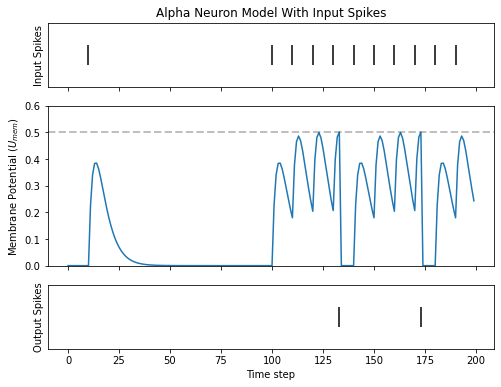

In [6]:
# input spike: initial spike, and then period spiking 
w = 0.85
spk_in = (torch.cat((torch.zeros(10), torch.ones(1), torch.zeros(89), 
                     (torch.cat((torch.ones(1), torch.zeros(9)),0).repeat(10))), 0) * w).unsqueeze(1)

# initialize parameters
syn_exc, syn_inh, mem = lif2.init_alpha()
mem_rec = []
spk_rec = []

# run simulation
for step in range(num_steps):
  spk_out, syn_exc, syn_inh, mem = lif2(spk_in[step], syn_exc, syn_inh, mem)
  mem_rec.append(mem.squeeze(0))
  spk_rec.append(spk_out.squeeze(0))

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_spk_mem_spk(spk_in, mem_rec, spk_rec, "Alpha Neuron Model With Input Spikes")

As with the Lapicque and Synaptic models, the Alpha model also has options to modify the threshold and reset mechanism.

## 2.2 Practical Considerations

As mentioned for the Synaptic neuron, the more complex a model, the more complex the backpropagation process during training. In my own experiments, I have yet to find a case where the Alpha neuron outperforms the Synaptic and Leaky neuron models. It seems as though learning through a positive and negative exponential only makes the gradient calculation process more difficult, and offsets any potential benefits in more complex neuronal dynamics.

However, when an SRM model is expressed as a time-varying kernel (rather than a recursive model as is done here), it seems to perform just as well as the simpler neuron models. As an example, see the following paper:

> [*Sumit Bam Shrestha and Garrick Orchard, "SLAYER: Spike layer error reassignment in time", Proceedings of the 32nd International Conference on Neural Information Processing Systems, pp. 1419-1328, 2018.*](https://arxiv.org/abs/1810.08646)

The Alpha neuron has been included with the intent of providing an option for porting across SRM-based models over into snnTorch, although natively training them seems to not be too effective here. 

# Conclusion

We have covered all LIF neuron models available in snnTorch. As a quick summary:

* **Lapicque**: a physically accurate model based directly on RC-circuit parameters
* **Leaky**: a simplified 1st-order model
* **Synaptic**: a 2nd-order model that accounts for synaptic current evolution
* **Alpha**: a 2nd-order model where the membrane potential tracks an alpha function

In general, `Leaky` and `Synaptic` seem to be the most useful for training a network. `Lapicque` is good for demonstrating physically precise models, while `Alpha` is only intended to capture the behaviour of SRM neurons. 

Building a network using these slighty more advanced neurons follows the exact same procedure as in [Tutorial 3](https://snntorch.readthedocs.io/en/latest/tutorials/index.html). 

For reference, the documentation [can be found here](https://snntorch.readthedocs.io/en/latest/snntorch.html).

## Further Reading
* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)
* [snnTorch documentation](https://snntorch.readthedocs.io/en/latest/snntorch.html) of the Lapicque, Leaky, Synaptic, and Alpha models
* [*Neuronal Dynamics:
From single neurons to networks and models of cognition*](https://neuronaldynamics.epfl.ch/index.html) by
Wulfram Gerstner, Werner M. Kistler, Richard Naud and Liam Paninski.
* [Theoretical Neuroscience: Computational and Mathematical Modeling of Neural Systems](https://mitpress.mit.edu/books/theoretical-neuroscience) by Laurence F. Abbott and Peter Dayan